# Finetuning Gemma2 for Tamil Texts

In [1]:
# Install Keras 3 last. See https://keras.io/getting_started/ for more details.
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

import os

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 256
num_data_limit = 100
lora_name = "tamil_lora"
lora_rank = 4
lr_value = 1e-4
train_epoch = 20
model_id = "gemma2_instruct_2b_en"

# Load Model

In [2]:
import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    input_text = f"<start_of_turn>user\n{prompt}<end_of_turn>\n<start_of_turn>model\n"
    output = gemma_lm.generate(input_text, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.")

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
<start_of_turn>user
தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
நீங்கள் எப்படி இருக்கிறீர்கள்? 

என்ன சொல்ல வேண்டும்? 
<end_of_turn>
TOTAL TIME ELAPSED: 15.78s


# Load Dataset

In [3]:
from datasets import load_dataset

# Load the Tamil Alpaca dataset
ds = load_dataset("abhinand/tamil-alpaca", split="train")
print(ds)

# Set tokenizer
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

# Prepare data
data = ds.with_format("np", columns=["input", "output"], output_all_columns=False)
train = []

for x in data:
    item = f"<start_of_turn>user\n{x['input']}\n<end_of_turn>\n<start_of_turn>model\n{x['output']}<end_of_turn>"
    length = len(tokenizer(item))
    if length < token_limit:
        train.append(item)
        if len(train) >= num_data_limit:
            break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

README.md:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

(…)-00000-of-00001-e96a6e4e7f400cce.parquet:   0%|          | 0.00/84.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51876 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output', 'text', 'system_prompt'],
    num_rows: 51876
})
100
<start_of_turn>user

<end_of_turn>
<start_of_turn>model
மூன்று முதன்மை நிறங்கள் சிவப்பு, நீலம் மற்றும் மஞ்சள். இந்த நிறங்கள் முதன்மை என்று அழைக்கப்படுகின்றன, ஏனெனில் அவை மற்ற வண்ணங்களை கலந்து உருவாக்க முடியாது மற்றும் மற்ற அனைத்து வண்ணங்களையும் பல்வேறு விகிதங்களில் இணைப்பதன் மூலம் உருவாக்க முடியும். ஒளிக்கு பயன்படுத்தப்படும் சேர்க்கை வண்ண அமைப்பில், முதன்மை நிறங்கள் சிவப்பு, பச்சை மற்றும் நீலம் (RGB).<end_of_turn>
<start_of_turn>user

<end_of_turn>
<start_of_turn>model
AI உதவியாளராக, எனக்கு என்னுடைய சொந்த அனுபவங்கள் அல்லது உடல் இருப்பு இல்லை. இருப்பினும், அல்காரிதம்கள், தர்க்கம் மற்றும் தரவு ஆகியவற்றின் அடிப்படையில் முடிவுகளை எடுக்க நான் திட்டமிடப்பட்டிருக்கிறேன். முரண்பட்ட தகவல் அல்லது பல சாத்தியமான முடிவுகள் இருப்பதால், முடிவெடுப்பது கடினமாக இருக்கும் சூழ்நிலையை நான் சந்திக்க நேரிடும். இதுபோன்ற சந்தர்ப்பங்களில், ஒவ்வொரு விருப்பத்தின் அபாயங்களையும் நன்மைகளையும் பகுப்பாய்வு ச

# LoRA Fine-tuning

In [4]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

# Save LoRA for each epoch

Epoch 1/20
 85/100 ━━━━━━━━━━━━━━━━━━━━ 10s 722ms/step - loss: 1.3033 - sparse_categorical_accuracy: 0.5296
Gemma output:
<start_of_turn>user
தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
நீங்கள் எப்படி இருக்கிறீர்கள்? 
<end_of_turn>
TOTAL TIME ELAPSED: 16.18s
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 777ms/step - loss: 1.2468 - sparse_categorical_accuracy: 0.5315
Epoch 2/20
 87/100 ━━━━━━━━━━━━━━━━━━━━ 6s 482ms/step - loss: 0.9301 - sparse_categorical_accuracy: 0.5834
Gemma output:
<start_of_turn>user
தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
இந்த மின்னஞ்சலை உருவாக்கவும்.<end_of_turn>
TOTAL TIME ELAPSED: 0.76s
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 428ms/step - loss: 0.9048 - sparse_categorical_accuracy: 0.5857
Epoch 3/20
 85/100 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - loss: 0.8141 - sparse_categorical_accuracy: 0.6081
Gemma output:
<start_of_turn>user
தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
மின்னஞ்ச

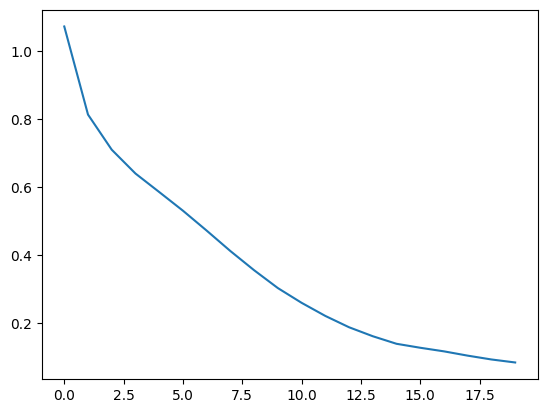

In [5]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_name = f"/kaggle/working/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
        gemma_lm.backbone.save_lora_weights(model_name)
        # Evaluate the model
        text_gen("தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.")

# Training with callback to save weights
history = gemma_lm.fit(train, epochs=train_epoch, batch_size=1, callbacks=[CustomCallback()])

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

# Load LoRA

Use the code below if you shared LoRA weights. It's much more lightweight than the model files themselves - for instance, a LoRA rank 4 weights file for a 10gb model might only be on the order of a few megabytes, easily shared over email.

In [6]:
# Example Code for Load LoRA
'''
import os
import keras
import keras_nlp

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_instruct_2b_en")
# Use the same LoRA rank that you trained
gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
gemma_lm.backbone.load_lora_weights(f"/kaggle/working/tamil_lora_4_epoch"+train_epoch+".lora.h5")
'''

'\nimport os\nimport keras\nimport keras_nlp\n\ngemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma2_instruct_2b_en")\n# Use the same LoRA rank that you trained\ngemma_lm.backbone.enable_lora(rank=4)\n\n# Load pre-trained LoRA weights\ngemma_lm.backbone.load_lora_weights(f"/kaggle/working/tamil_lora_4_epoch"+train_epoch+".lora.h5")\n'

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [7]:
gemma_lm.compile(sampler="top_k")
text_gen("தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.")
text_gen("தொடர்பான பிற செய்திகளை தமிழில் உருவாக்கவும்.")


Gemma output:
<start_of_turn>user
தமிழில் ஒரு மின்னஞ்சல் பதிலை உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
மின்னஞ்சல் பதிலை உருவாக்கப்பட்டதும், உங்கள் மின்னஞ்சலை ஏற்றி உங்கள் மின்னஞ்சலை ஏறுவிட்டு அனுப்பிவைக்கிறேன்.<end_of_turn>
TOTAL TIME ELAPSED: 18.47s

Gemma output:
<start_of_turn>user
தொடர்பான பிற செய்திகளை தமிழில் உருவாக்கவும்.<end_of_turn>
<start_of_turn>model
மூடி இருந்த பிற செய்திகள் தொடர்ந்து வந்தன, வானிலை மாற்றி மழை எடுக்க வைத்தவை. ஒவ் hoofமும் தண்ணீர் சிரித்தது, உட்பகுதிகளில் அலர்ஜிய ஏற்பட்டன. பலர் வீடுகளை வெளியேறி இயற்கையின் கடினத்தகுப்பையை கேட்டனர். தொடர்ந்து வானிலை மாற்றமும் மிகவும் பரிமாற்றமாக இருந்தது, வார்த்தைகளால் விவரிக்க முடியாத அளவிலான அ might மற்றும் சூழ்நிலைகளால் பல்வேறு விலங்குகள் மற்றும் தீவிர செயலங்களை உண்டாக்கியன.<end_of_turn>
TOTAL TIME ELAPSED: 7.31s


Try a slight different prompts

In [8]:
text_gen("புதிய செய்திக்கு பதில் தமிழ் மொழியில் கொடுக்கவும்.")
text_gen("தொடர்பான தகவல்களை தமிழில் அளிக்கவும்.")
text_gen("அடுத்து வரும் தகவலுக்கு தமிழில் பதில் வழங்கவும்.")


Gemma output:
<start_of_turn>user
புதிய செய்திக்கு பதில் தமிழ் மொழியில் கொடுக்கவும்.<end_of_turn>
<start_of_turn>model
அத энциклопедияக்களவில் இப்போது வெளியிடப்பட்ட செய்தி.<end_of_turn>
TOTAL TIME ELAPSED: 1.08s

Gemma output:
<start_of_turn>user
தொடர்பான தகவல்களை தமிழில் அளிக்கவும்.<end_of_turn>
<start_of_turn>model
அவரு cùng தொடர்பில் உள்ள எத்தனை தகவல்கள்있음.<end_of_turn>
TOTAL TIME ELAPSED: 1.12s

Gemma output:
<start_of_turn>user
அடுத்து வரும் தகவலுக்கு தமிழில் பதில் வழங்கவும்.<end_of_turn>
<start_of_turn>model
அடுத்து வரும் தகவலுக்கு பதில் "அடுத்து வரும் தகவல்" (of the next information) தமிழில் "அடுத்து வரும் தகவல்கள்" (of the next information) என்று மாற்றலாம்.<end_of_turn>
TOTAL TIME ELAPSED: 2.58s
